# Imports

In [24]:
!pip install datasets transformers --quiet



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import BertTokenizerFast

# Check device


In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)


Device: cuda


# Load AG News Dataset

In [32]:
dataset = load_dataset("ag_news")


'(ProtocolError('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)), '(Request ID: c60be6d7-8b18-4c08-b3a7-eea334a5fa7d)')' thrown while requesting HEAD https://huggingface.co/datasets/ag_news/resolve/main/README.md
Retrying in 1s [Retry 1/5].


In [33]:
train_set = dataset['train']
test_set = dataset['test']

In [34]:
print(f"Train size: {len(train_set)}, Test size: {len(test_set)}")
print("Example:", train_set[0])

Train size: 120000, Test size: 7600
Example: {'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [35]:
train_set.shape

(120000, 2)

In [36]:
train_set.column_names

['text', 'label']

# Tokenizer

In [37]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization + Padding + Truncation


In [38]:
def tokenize(batch):
    return tokenizer(
        batch['text'],
        padding='max_length',
        truncation=True,
        max_length=20
    )

## Map_style

In [39]:
train_dataset = train_set.map(tokenize, batched=True)
test_dataset = test_set.map(tokenize, batched=True)


# Set Format for PyTorch

In [40]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# DataLoader


In [41]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check a batch


In [42]:
batch = next(iter(train_loader))
batch

{'label': tensor([3, 3, 2, 1, 3, 2, 1, 1, 2, 2, 3, 2, 3, 2, 0, 0, 0, 3, 1, 3, 0, 1, 1, 2,
         2, 1, 0, 0, 0, 0, 0, 2]),
 'input_ids': tensor([[  101, 11603,  2089,  2373,  2148,  4759,  2816,  2019,  2035,  1011,
          19998,  2933,  2003,  2036,  2108,  2641,  1010,  2021,  1996,   102],
         [  101,  5738, 15008,  1005,  2086,  1010, 12959,  2088, 24185,  1006,
           9706,  1007,  9706,  1011,  1996,  3256,  2003, 13721,  1998,   102],
         [  101,  1053, 19650,  2000,  7392,  2007, 10819,  2005,  1032,  1002,
           5539,  2454,  1053, 19650,  4806,  2248,  4297,  1012,  1006,   102],
         [  101,  3435,  2707,  2000,  2489,  4034,  2005,  5583,  5521,  5828,
           5583,  5521,  2288,  2125,  2000,  1037,  3435,  2707,  1999,   102],
         [  101,  1053,  1037,  1024,  8370,  4707,  2343,  2006,  3045,  6960,
          19884,  1996,  6960,  8370,  4707,  1010,  3005,  3260,  2003,   102],
         [  101, 15505,  9739,  1024,  4610, 28657, 16493

In [43]:
print("Input IDs shape:", batch['input_ids'].shape)
print("Labels shape:", batch['label'].shape)

Input IDs shape: torch.Size([32, 20])
Labels shape: torch.Size([32])


# Utils

In [44]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


# Model

In [45]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, RNN_type, vocab_size, embedding_dim, hidden_size, num_layers, bidirectional, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = RNN_type(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len] -> [batch, seq_len, embed_dim]d
        outputs, _ = self.rnn(x)  # [batch, seq_len, hidden*directions]
        outputs = outputs.mean(dim=1)  # average pooling over sequence length
        y = self.fc(outputs)  # [batch, num_classes]
        return y


In [ ]:
import torch.nn as nn

class TextRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, bidirectional, num_classes, rnn_type='LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        #  RNN
        if rnn_type.upper() == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=embed_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True
            )
        elif rnn_type.upper() == 'GRU':
            self.rnn = nn.GRU(
                input_size=embed_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True
            )
        else:
            self.rnn = nn.RNN(
                input_size=embed_dim,
                hidden_size=hidden_dim,
                num_layers=num_layers,
                bidirectional=bidirectional,
                batch_first=True
            )
        
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, x):
        x = self.embedding(x)               # [batch, seq_len, embed_dim]
        outputs, _ = self.rnn(x)           # [batch, seq_len, hidden_dim*directions]
        outputs = outputs.mean(dim=1)      # mean over seq_len
        out = self.fc(outputs)             # [batch, num_classes]
        return out


In [ ]:
vocab_size = tokenizer.vocab_size  # معمولاً 30522 برای BERT
embed_dim = 128
hidden_dim = 128
num_layers = 1
bidirectional = True
num_classes = 4
rnn_type = 'LSTM'  # or 'LSTM' or 'GRU' or 'RNN'

model = TextRNN(vocab_size, embed_dim, hidden_dim, num_layers, bidirectional, num_classes, rnn_type)
model.to(device)


# Select Parameters and Models

In [46]:
vocab_size = tokenizer.vocab_size
embedding_dim = 64
hidden_size = 128
num_layers = 1
bidirectional = True
num_classes = 4

model = RNNModel(nn.LSTM, vocab_size, embedding_dim, hidden_size,
                 num_layers, bidirectional, num_classes).to(device)
print(model)


RNNModel(
  (embedding): Embedding(30522, 64)
  (rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)


# Test One batch

In [ ]:
batch = next(iter(train_loader))
inputs = batch['input_ids'].to(device)
labels = batch['label'].to(device)
outputs = model(inputs)
print("Output shape:", outputs.shape)  # باید [batch_size, num_classes] باشه


Output shape: torch.Size([32, 4])


# Training Function

In [58]:
from tqdm import tqdm
from torchmetrics import Accuracy

In [ ]:

def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_meter = AverageMeter()
    acc_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)

    loop = tqdm(train_loader, leave=False)
    for batch in loop:
        inputs = batch['input_ids'].to(device)
        targets = batch['label'].to(device)
        
        # forward
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_meter.update(loss.item())
        acc_metric(outputs, targets)

        loop.set_description(f"Epoch {epoch}" if epoch is not None else "")
        loop.set_postfix(loss=loss_meter.avg, accuracy=100.*acc_metric.compute().item())
    return loss_meter.avg, acc_metric.compute().item()


# Validation Function

In [49]:
def validation(model, test_loader, loss_fn):
    model.eval()
    loss_meter = AverageMeter()
    acc_metric = Accuracy(task="multiclass", num_classes=4).to(device)

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            loss_meter.update(loss.item(), n=inputs.size(0))
            acc_metric.update(outputs, labels.int())

    avg_loss = loss_meter.avg
    avg_acc = acc_metric.compute().item()
    return avg_loss, avg_acc


# Define Loss & Optimizer

In [ ]:
import torch.optim as optim

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Training Loop

In [ ]:
num_epochs = 5  
best_val_loss = float('inf')

train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = validation(model, test_loader, loss_fn)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    print(f"\nEpoch {epoch}:Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # ذخیره بهترین مدل
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_val_loss = val_loss
        print("Best model saved!")



Epoch 1/5


Train Loss: 0.0799, Train Acc: 0.9722
Val   Loss: 0.5905, Val   Acc: 0.8607
Best model saved!

Epoch 2/5


Train Loss: 0.0677, Train Acc: 0.9769
Val   Loss: 0.6380, Val   Acc: 0.8612

Epoch 3/5


Train Loss: 0.0551, Train Acc: 0.9809
Val   Loss: 0.6841, Val   Acc: 0.8604

Epoch 4/5


Train Loss: 0.0474, Train Acc: 0.9847
Val   Loss: 0.6983, Val   Acc: 0.8620

Epoch 5/5


Train Loss: 0.0390, Train Acc: 0.9875
Val   Loss: 0.7130, Val   Acc: 0.8580


# Plot Results

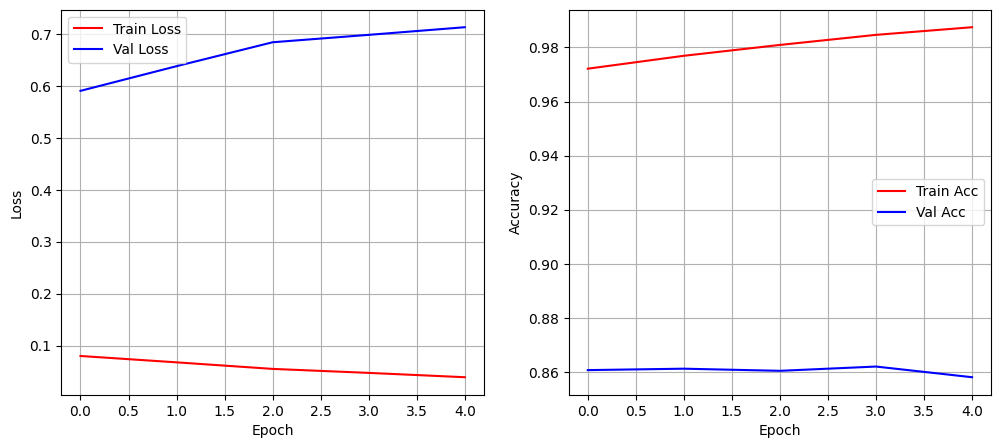

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_hist, 'r-', label='Train Loss')
plt.plot(val_loss_hist, 'b-', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(train_acc_hist, 'r-', label='Train Acc')
plt.plot(val_acc_hist, 'b-', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


# Inference Example

In [64]:
model.eval()
sample_texts = ["Apple is releasing a new product.", "The stock market is crashing!"]
max_length=20
# Tokenize
inputs = tokenizer(sample_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)

# Predict
with torch.no_grad():
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1)

for text, pred in zip(sample_texts, preds):
    print(f"Text: {text} => Predicted class: {pred.item()}")


Text: Apple is releasing a new product. => Predicted class: 3
Text: The stock market is crashing! => Predicted class: 3


In [87]:
labels.unique()

tensor([0, 1, 2, 3], device='cuda:0')

In [88]:
label_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

def predict(text, model, tokenizer, device, max_length=20):
    # Tokenize و تبدیل به tensor
    encoded = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = encoded['input_ids'].to(device)

    # predict
    with torch.no_grad():
        outputs = model(input_ids)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
    
    return label_map[pred_class], probs.squeeze().cpu().numpy()


In [ ]:

def predict_text(text, model, tokenizer, max_length=20):
    model.eval()

    # tokenize
    encoded = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids)
        pred = torch.argmax(outputs, dim=1).item()

    return label_map[pred]


In [89]:
texts = [
    "Apple releases new iPhone with amazing features",
    "The stock market crashed today due to economic fears",
    "Manchester United won their last football match",
    "Scientists discovered a new species in the Amazon"
]

for t in texts:
    cls, probs = predict(t, model, tokenizer, device)
    print(f"Text: {t}")
    print(f"Predicted class: {cls}, Probabilities: {probs}\n")


Text: Apple releases new iPhone with amazing features
Predicted class: Sci/Tech, Probabilities: [3.8103430e-11 1.8604751e-09 8.9544839e-05 9.9991047e-01]

Text: The stock market crashed today due to economic fears
Predicted class: Business, Probabilities: [1.2705035e-09 1.2013975e-10 9.9999976e-01 2.5353586e-07]

Text: Manchester United won their last football match
Predicted class: Sports, Probabilities: [5.1811355e-10 9.9998116e-01 1.8492005e-05 3.0956082e-07]

Text: Scientists discovered a new species in the Amazon
Predicted class: Sci/Tech, Probabilities: [2.5127295e-10 4.1744534e-18 9.2173817e-05 9.9990785e-01]



In [90]:
text = "Apple released a new AI chip for faster computers"
result = predict(text, model, tokenizer,device)

print("Text:", text)
print("Prediction:", result)


Text: Apple released a new AI chip for faster computers
Prediction: ('Sci/Tech', array([3.0288688e-10, 3.1666923e-14, 1.9323206e-06, 9.9999809e-01],
      dtype=float32))


# Checking accuracy on the test

In [ ]:
from tqdm import tqdm

all_preds, all_labels = [], []

for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(device)
    labels = batch['label'].to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        preds = torch.argmax(outputs, dim=1)
    all_preds.append(preds)
    all_labels.append(labels)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = (all_preds == all_labels).float().mean()
print(f"Test Accuracy: {accuracy:.4f}")


100%|███████████████████████████████████████████████████████████████████████████████| 238/238 [00:02<00:00, 113.36it/s]

Test Accuracy: 0.8580


# evaluation mode

In [76]:
model.eval()


RNNModel(
  (embedding): Embedding(30522, 64)
  (rnn): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

In [93]:
torch.save(model.state_dict(), "best_model.pt")


In [92]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
